# Python Scraping

Der folgende Code scraped die Webseite https://www.bundesanzeiger.de/. 

## Imports:

In [1]:
from bs4 import BeautifulSoup
import requests
import csv
from PIL import Image
from io import StringIO
from io import BytesIO
from IPython.display import display, HTML
from datetime import datetime
import time
import pandas as pd

## Globale Variablen:

In [2]:
session_requests = requests.session()
session_id = ""





# Functions:

## get_search_results

Diese Funktion stellt eine Anfrage an die Suchmaske und gibt die Ergebnistabelle als Dataframe zurück.

In [3]:
def get_search_results(search_string):
    global session_id
    payload = {'page.navid': 'to_detailsearch', 'global_data.designmode': 'eb', '(page.navid=to_quicksearchlist)': 'Suchen', 'genericsearch_param.part_id': '', 'genericsearch_param.hitsperpage': '10'}
    payload.update({'genericsearch_param.fulltext': search_string})
    if session_id != "":
        payload.update({'session.sessionid': session_id})

    url = 'https://www.bundesanzeiger.de/ebanzwww/wexsservlet'
    result = session_requests.get(url, params = payload)
    print("get_searchresults returned:", result.status_code, result.headers['content-type'])

    # Parse the html content
    soup = BeautifulSoup(result.text, "lxml")
    # Parse for session id, update variable
    session_id = soup.find('a', href=True)['href']
    session_id = session_id[session_id.find("session.sessionid=")+len("session.sessionid="):session_id.find("&", session_id.find("session.sessionid="))]
    print("session_id:", session_id)

    # parse
    result_table = soup.find("table", attrs={"class": "result", "summary": "Trefferliste"})
    rows = result_table.find_all("tr")
    table_contents = []
    for tr in rows:
        if rows.index(tr) == 0 : 
            row_cells = [ th.getText(separator=" ").strip() for th in tr.find_all('th') if th.getText().strip() != '' ] + ["session.sessionid=", "fts_search_list.selected", "fts_search_list.destHistoryId", "timestamp"] 
        else : 
            row_cells = ([ tr.find('th').getText(separator=" ") ] if tr.find('th') else [] ) + \
            [ td.getText(separator=" ").strip() for td in tr.find_all('td') if td.getText().strip() != '' ] + \
            [ a['href'][a['href'].find("session.sessionid=")+len("session.sessionid="):a['href'].find("&", a['href'].find("session.sessionid="))] for a in tr.find_all('a', href=True)] + \
            [ a['href'][a['href'].find("fts_search_list.selected=")+len("fts_search_list.selected="):a['href'].find("&", a['href'].find("fts_search_list.selected="))] for a in tr.find_all('a', href=True)] + \
            [ a['href'][a['href'].find("fts_search_list.destHistoryId=")+len("fts_search_list.destHistoryId="):] for a in tr.find_all('a', href=True)] + \
            [ time.ctime() ]
        if len(row_cells) > 1 : 
            table_contents += [ row_cells ]

    df = pd.DataFrame.from_dict(table_contents)
    df.columns = df.iloc[0]
    df = df[1:]
    return df

## get_captcha

Bevor eine Anfrage nach einem Dokument mit dem gewünschen Ergebnis beantwortet wird, muss der User ein Captcha lösen. Hier wird die Lösung dem Nutzer gezeigt und seine Eingabe verlangt.

Diese Funktion wird von get_details aufgerufen.

In [4]:
def get_captcha(session_id):
    payload = {'state.action':'captcha','captcha_data.mode':'image'}
    payload.update({'session.sessionid': session_id})
    url = 'https://www.bundesanzeiger.de/ebanzwww/contentloader'
    result = session_requests.get(url, params = payload)
    print("get_captcha returned:", result.status_code, result.headers['content-type'])
    
    if result.headers['content-type'] == "image/jpeg":
        img = Image.open(BytesIO(result.content))
        display(img)
        print('Please solve this captcha. To cancel, type ""exit""')
        captcha_solution = ""
        captcha_solution = input()
        return captcha_solution
    else:
        print("no image returned")
        return ""

## get_details

Sobald aus dem Ergebnistabelle ein Detail angefragt werden soll, muss diese Funktion aufgerufen werden. Sie fragt die Details ab und überprüft auf Captchas.

In [5]:
def get_details(search_list_selected, search_list_destHistoryId):
    global session_id
    payload = {'page.navid':'detailsearchlisttodetailsearchdetail'}
    payload.update({'session.sessionid': session_id})
    payload.update({'fts_search_list.selected': search_list_selected})
    payload.update({'fts_search_list.destHistoryId': search_list_destHistoryId})
    url = 'https://www.bundesanzeiger.de/ebanzwww/wexsservlet'
    time.sleep(2)
    result = session_requests.get(url, params = payload)
    print("get_details returned:", result.status_code, result.headers['content-type'])

    # Parse the html content
    soup = BeautifulSoup(result.text, "lxml")
    # Parse for session id, update variable
    session_id = soup.find('a', href=True)['href']
    session_id = session_id[session_id.find("session.sessionid=")+len("session.sessionid="):session_id.find("&", session_id.find("session.sessionid="))]
    # check if page has a captcha
    if soup.find("div", attrs={"class": "image_captcha"}) != None:
        #print("Captcha found")
        captcha_found = True
        captcha_solution = ""
        captcha_solution = get_captcha(session_id)
        if captcha_solution == "" or captcha_solution == "exit":
            return ""
        else:
            while captcha_found == True:
                # POST captcha solution
                post_payload = {"genericsearch_param.part_id":"","(page.navid=detailsearchdetailtodetailsearchdetailsolvecaptcha)":"OK"}
                post_payload.update({'session.sessionid': session_id})
                post_payload.update({'captcha_data.solution': captcha_solution})
                post_url = 'https://www.bundesanzeiger.de/ebanzwww/wexsservlet'
                result = session_requests.post(post_url, data = post_payload)
                print("post_captcha returned: ", result.status_code, result.headers['content-type'])
                # Check for captcha again
                soup = BeautifulSoup(result.text, "lxml")
                # Parse for session id, update variable
                session_id = soup.find('a', href=True)['href']
                session_id = session_id[session_id.find("session.sessionid=")+len("session.sessionid="):session_id.find("&", session_id.find("session.sessionid="))]
                # check if page has a captcha
                if soup.find("div", attrs={"class": "image_captcha"}) != None:
                    print("WRONG captcha, NEW captcha found -- PLEASE TRY AGAIN")
                    captcha_found = True
                    captcha_solution = ""
                    captcha_solution = get_captcha(session_id)
                    if captcha_solution == "" or captcha_solution == "exit":
                        return ""
                else:
                    captcha_found = False
                    print("Captcha successfully solved!")
                    return soup
            return soup
    else:
        return soup

# Ausführung:

Suchstring definieren, Webseite durchsuchen und Ergebnistabelle als csv wegschreiben, dann die einzelnen Details scrapen.

get_searchresults returned: 200 text/html;charset=utf-8
session_id: 2b3591b7017ab74223e493640bf63fbd
next: Wilke Waldecker Fleisch- und Wurstwaren GmbH & Co. KG Twistetal Dokument vom 30.01.2019
get_details returned: 200 text/html;charset=utf-8
next: Wilke Waldecker Fleisch- und Wurstwaren GmbH & Co. KG Twistetal Dokument vom 25.07.2017
get_details returned: 200 text/html;charset=utf-8
get_captcha returned: 200 image/jpeg


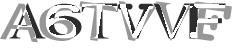

Please solve this captcha. To cancel, type ""exit""
A6TVVF
post_captcha returned:  200 text/html;charset=utf-8
Captcha successfully solved!
next: Wilke Waldecker Fleisch- und Wurstwaren GmbH & Co. KG Twistetal Dokument vom 08.11.2016
get_details returned: 200 text/html;charset=utf-8
get_captcha returned: 200 image/jpeg


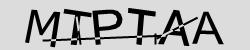

Please solve this captcha. To cancel, type ""exit""
MTPTAA
post_captcha returned:  200 text/html;charset=utf-8
Captcha successfully solved!
next: Wilke Waldecker Fleisch- und Wurstwaren GmbH & Co. KG Twistetal Dokument vom 03.02.2016
get_details returned: 200 text/html;charset=utf-8
get_captcha returned: 200 image/jpeg


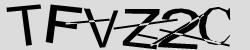

Please solve this captcha. To cancel, type ""exit""
TFVZ2B
post_captcha returned:  200 text/html;charset=utf-8
WRONG captcha, NEW captcha found -- PLEASE TRY AGAIN
get_captcha returned: 200 image/jpeg


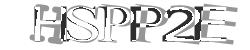

Please solve this captcha. To cancel, type ""exit""
HSPP2E
post_captcha returned:  200 text/html;charset=utf-8
Captcha successfully solved!
Done!


In [9]:
search_string = "Wilke Wurstwaren"

df = get_search_results(search_string)
df.to_csv(search_string+'_search_results.csv', index=False, encoding='utf-8', sep=';', quoting=csv.QUOTE_ALL)

keepcharacters = (' ','.','_')
    

for index, row in df.iterrows():
    if index < 5:
        print("next:", row[0], "Dokument vom", row[3])
        html_result = get_details(row[6], row[7])
        if html_result != "":
            with open(time.strftime("%Y-%m-%d")+" "+"".join(c for c in row[0] if c.isalnum() or c in keepcharacters).rstrip()+"_"+row[3]+".html", "w", encoding='utf-8') as file:
                file.write(str(html_result))
        
print("Done!")